In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from data_processing import make_classification, fetch_covtype, create_dataset
from MLP import MLP
from rainbow_MLP import rainbow_MLP
from testing import test
from torch.utils.data import DataLoader
from tqdm import tqdm
from training import train
from utils import check_normalisation, plot_results_2D, check_alignement, Marchenko_Pastur, plot_spectra

## Génération des données

In [2]:
X, y = make_classification(n_samples=5000, n_features=10, n_redundant=0, n_informative=10, n_classes=4)
#X, y = fetch_covtype()

train_data, val_data, test_data = create_dataset(X, y, normalize = True, prop_val = 0.7, prop_test = 0.15)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Entraînement d'un modèle cible

On alignera tous les modèles entraînés par la suite sur celui-ci.

True
[INFO] training using cuda:2.
Initial roc_auc_score (validation): 0.47519806375197077
Epoch [1/10], Loss_error (train): 0.5828, Roc_auc_score (validation): 0.9735432663965963
Epoch [2/10], Loss_error (train): 0.3779, Roc_auc_score (validation): 0.9791791129993334
Epoch [3/10], Loss_error (train): 0.2906, Roc_auc_score (validation): 0.9800165714260151
Epoch [4/10], Loss_error (train): 0.2636, Roc_auc_score (validation): 0.9807475538699948
Epoch [5/10], Loss_error (train): 0.2362, Roc_auc_score (validation): 0.9818487120347988
Epoch [6/10], Loss_error (train): 0.1981, Roc_auc_score (validation): 0.9856905045957903
Epoch [7/10], Loss_error (train): 0.1900, Roc_auc_score (validation): 0.9831875344109848
Epoch [8/10], Loss_error (train): 0.1944, Roc_auc_score (validation): 0.9822911683797781
Epoch [9/10], Loss_error (train): 0.1762, Roc_auc_score (validation): 0.985087739488803
Epoch [10/10], Loss_error (train): 0.1531, Roc_auc_score (validation): 0.9855017046448121


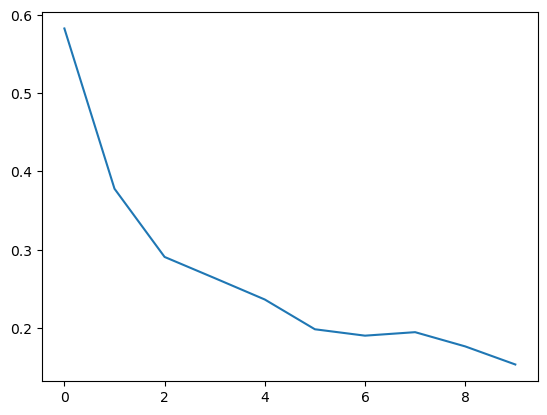

Test roc_auc_score:  0.9836705699737616 .


In [3]:
target_layer_size = 300
hidden_layer_sizes = [target_layer_size, target_layer_size, target_layer_size, np.max(train_data.tensors[1].numpy())+1]
target_model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)

print(torch.cuda.is_available())
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}.".format(DEVICE))

target_model.to(DEVICE)

train(target_model, train_dataloader, val_dataloader, 10, len(train_data), DEVICE, text = True, plot = True)
_ = test(target_model, test_dataloader, len(test_data), DEVICE)

Affichage des spectres de ses covariances en fonction du rang des valeurs propres. 

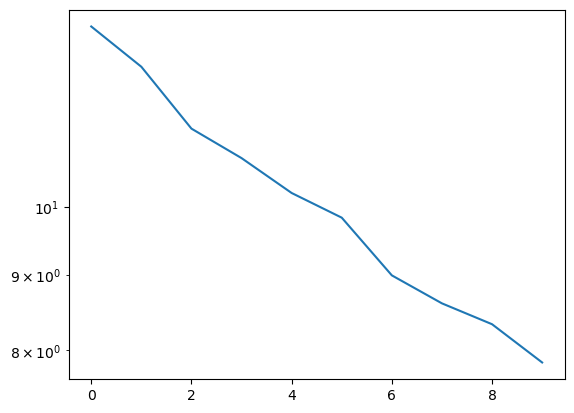

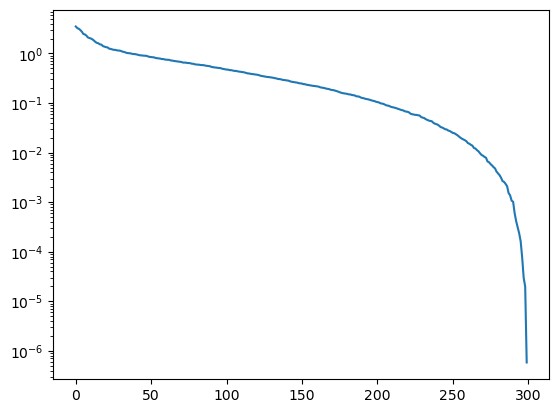

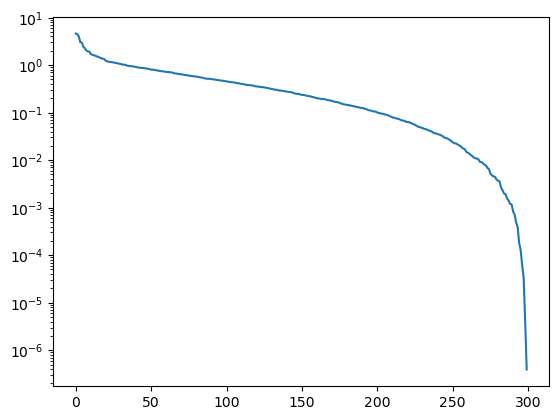

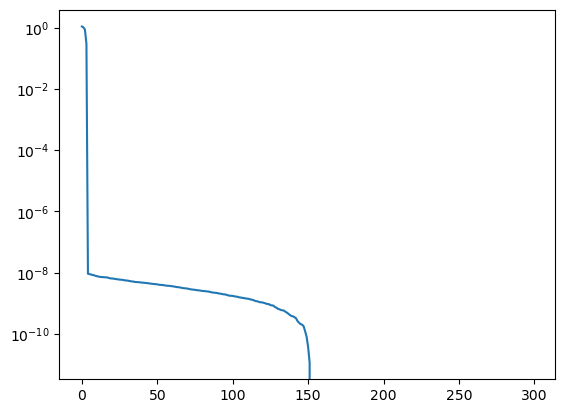

In [4]:
covariances_eig_val = target_model.covariances_eigval(plot = "rank")

Entraînements de nouveaux modèles, alignement de leurs covariances et affichage des spectres (pour la deuxième covariance).

Nb runs :  1 .


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


Nb runs :  10 .


100%|███████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]


Nb runs :  50 .


100%|███████████████████████████████████████████| 50/50 [02:15<00:00,  2.70s/it]


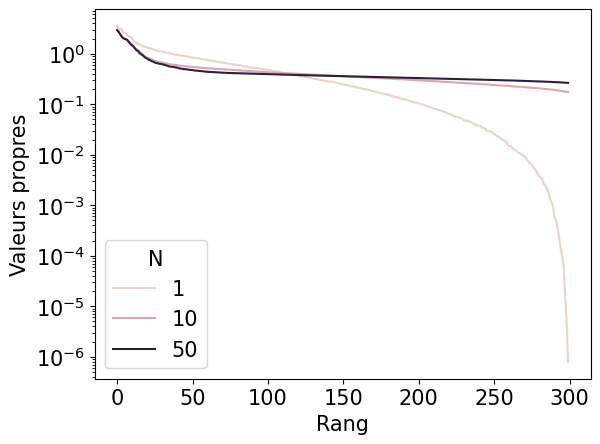

In [65]:
aligned_covariances_2 = 0
nb_runs = [1, 10, 50]

results_covariances = pd.DataFrame(columns=['N', 'Rang', 'Valeurs propres'])
aligned_covariances_2_list = []

for nb_run in nb_runs:
    print('Nb runs : ', nb_run, '.')
    
    aligned_covariances_2 = 0

    for run in tqdm(range(nb_run)):
        model = MLP(train_data[0][0].shape[0], hidden_layer_sizes, batch_norm = True)
        model.to(DEVICE)

        train(model, train_dataloader, val_dataloader, 10, len(train_data), DEVICE, text = False, plot = False)

        aligned_covariances = model.get_aligned_covariances(X, target_model, DEVICE)
        #aligned_covariances = model.get_covariances()
        aligned_covariances_2 += aligned_covariances[0]
    
    aligned_covariances_2 /= nb_run
    aligned_covariances_2_list.append(aligned_covariances_2)
    
    evs = np.flip(np.linalg.eigh(aligned_covariances_2)[0])
    
    for rg, ev in enumerate(evs):
        results_covariances = pd.concat([results_covariances, pd.DataFrame([[nb_run, rg, ev]],
                                columns=results_covariances.columns)], ignore_index=True)
        
sns.lineplot(data=results_covariances, x="Rang", y="Valeurs propres", hue="N", markers=True, dashes=False)
plt.yscale('log')

Histogramme du spectre estimé sur 50 réseaux.

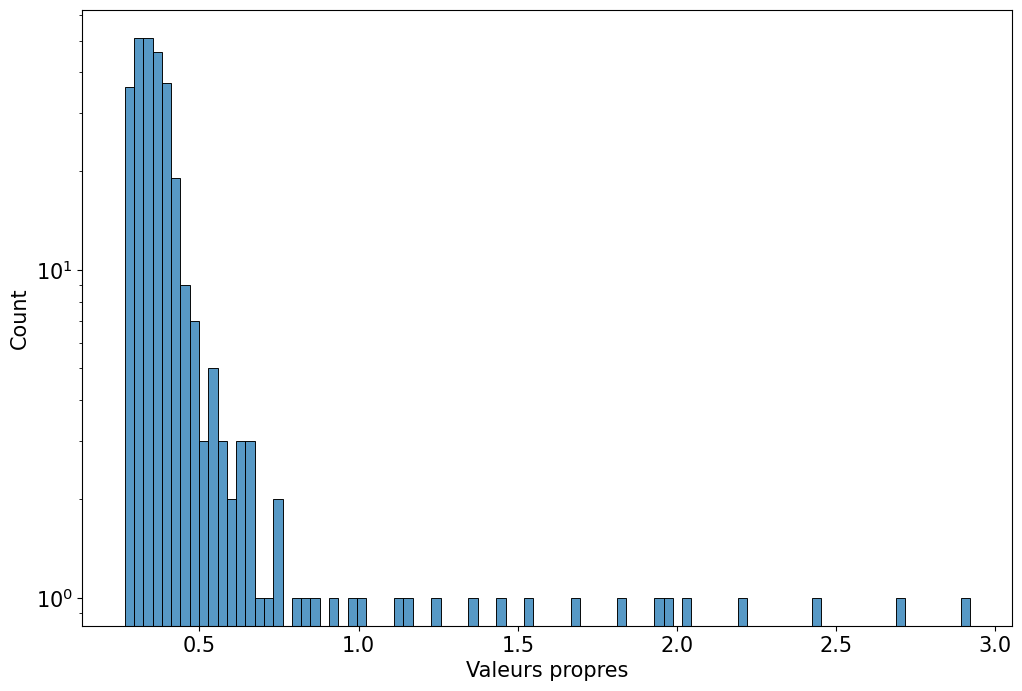

In [116]:
plt.figure(figsize=(12,8))

sns.histplot(data=results_covariances.query('N==50'), x="Valeurs propres")
plt.yscale('log')
#plt.savefig('fig/spectra_N50.pdf')
#plot_spectra(aligned_covariances_2)

## Déviation par rapport à la loi de MP

On commence par afficher l'histogramme du spectre estimé sur 10 réseaux et une approximation (manuelle) par Marchenko-Pastur.

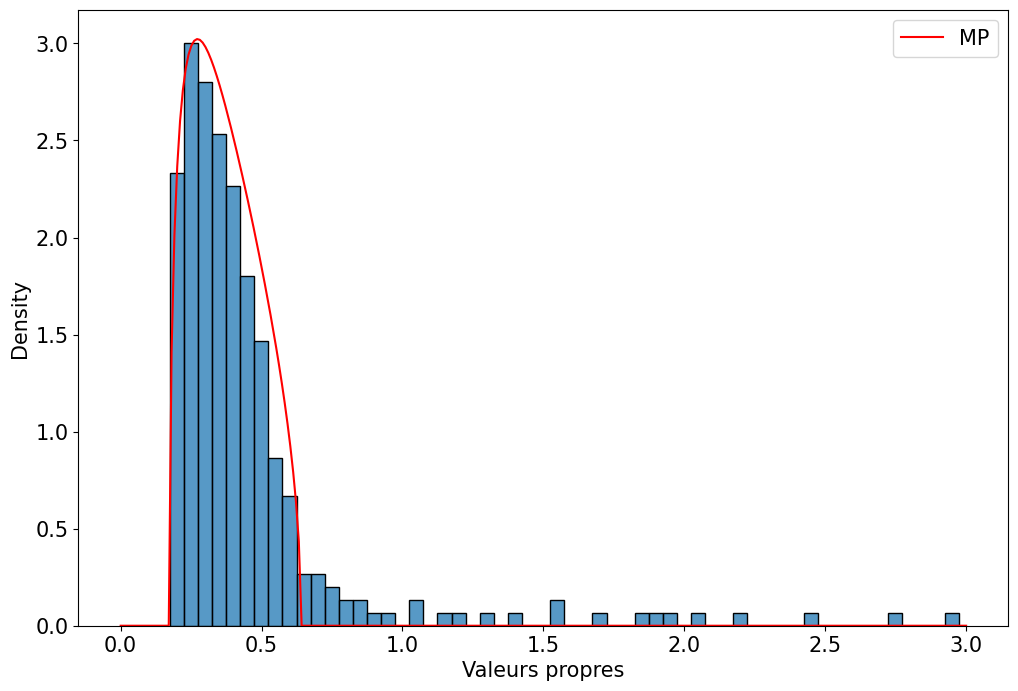

In [165]:
plt.figure(figsize=(12,8))

sns.histplot(data=results_covariances.query('N==10'), x="Valeurs propres", binwidth=.05, stat="density")
MP_c = Marchenko_Pastur(np.linspace(0,3,300), .1, sigma2=.37)
plt.plot(np.linspace(0,3,300), MP_c, c='r', label='MP')
plt.legend()
#plt.savefig('fig/spectra_N10_MP.pdf')
#plt.show()

On blanchit cette matrice avec la covariance estimée sur 50 réseaux, pour obtenir un histogramme beaucoup mieux expliqué par MP.

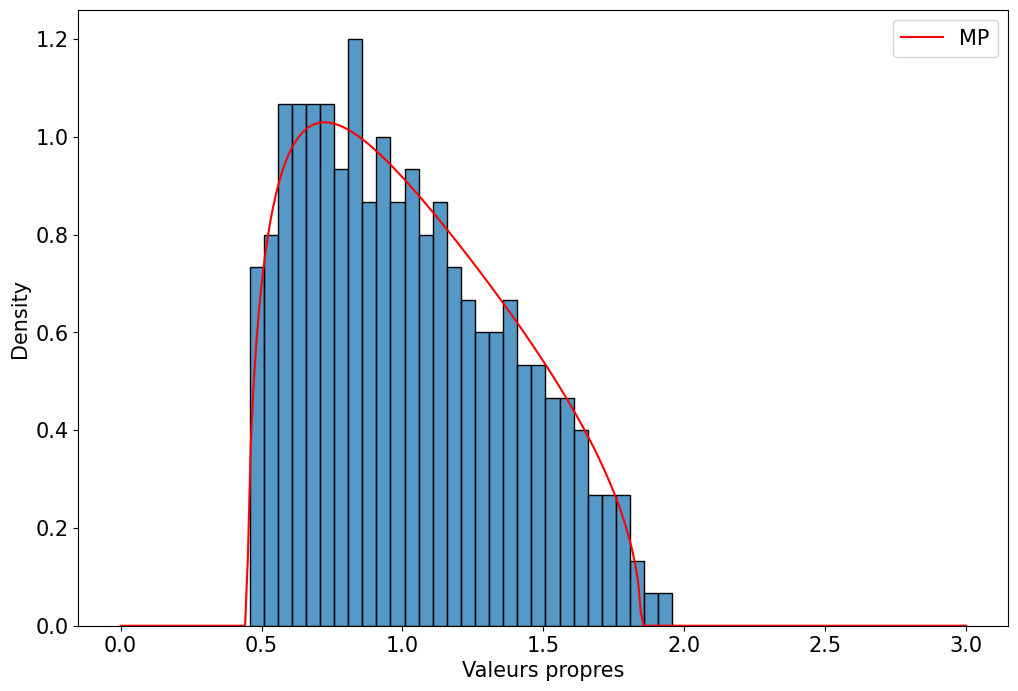

In [247]:
plt.figure(figsize=(12,8))

weight = model.layers[3].weight.to('cpu').detach().numpy()
C_sqrt = scipy.linalg.sqrtm(aligned_covariances_2)
inv_C_sqrt = np.linalg.inv(C_sqrt)
whitened_cov = inv_C_sqrt.T@aligned_covariances_2_list[1]@inv_C_sqrt
results_whitened_cov = pd.DataFrame(data=np.linalg.eigh(whitened_cov)[0], columns=['Valeurs propres'])
sns.histplot(data=results_whitened_cov, x="Valeurs propres", binwidth=.05, stat="density")

MP_w = Marchenko_Pastur(np.linspace(0,3,300), .115, sigma2=1.03)
plt.plot(np.linspace(0,3,300), MP_w, c='r', label='MP')
plt.legend()
#plt.savefig('fig/spectra_N10_w_MP.pdf')
#plt.show()